# DDPG Agent

In [1]:
"""
Deep Deterministic Policy Gradient (DDPG)

"""

import argparse
import os
import time

import gym
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'

import numpy as np
import tensorflow as tf

import keras
import random
import copy

'''
# add arguments in command  --train/test
parser = argparse.ArgumentParser(description='Train or test neural net motor controller.')
parser.add_argument('--train', dest='train', action='store_true', default=False)
parser.add_argument('--test', dest='test', action='store_true', default=True)
args = parser.parse_args()
'''

#####################  hyper parameters  ####################

# MountainCarContinuous-v0  Pendulum-v0
ENV_ID = 'Pendulum-v0'  # environment id
RANDOM_SEED = 2  # random seed, can be either an int number or None
RENDER = False  # render while training

ALG_NAME = 'DDPG'
TRAIN_EPISODES = 4000  # total number of episodes for training
TEST_EPISODES = 10  # total number of episodes for training
MAX_STEPS = 200  # total number of steps for each episode

LR_A = 0.000001  # learning rate for actor
LR_C = 0.000002  # learning rate for critic
GAMMA = 0.9  # reward discount
TAU = 0.01  # soft replacement
MEMORY_CAPACITY = 10000  # size of replay buffer
BATCH_SIZE = 32  # update action batch size
VAR = 6  # control exploration

###############################  DDPG  ####################################


class DDPG(object):
    """
    DDPG class
    """

    def __init__(self, action_dim, state_dim, action_range):
        self.memory = np.zeros((MEMORY_CAPACITY, state_dim * 2 + action_dim + 1), dtype=np.float32)
        self.pointer = 0
        self.action_dim, self.state_dim, self.action_range = action_dim, state_dim, action_range
        self.var = VAR

        W_init = tf.random_normal_initializer(mean=0, stddev=0.3)
        b_init = tf.constant_initializer(0.1)

        def get_actor(input_state_shape, name=''):
            """
            Build actor network
            :param input_state_shape: state
            :param name: name
            :return: act
            """
            input_layer = keras.layers.Input(input_state_shape, name='A_input')
            layer = keras.layers.Dense(64, activation=tf.nn.relu, name='A_l1')(input_layer)
            layer = keras.layers.Dense(64, activation=tf.nn.relu, name='A_l2')(layer)
            layer = keras.layers.Dense(action_dim, activation=tf.nn.sigmoid, name='A_a')(layer)
            layer = keras.layers.Lambda(lambda x: action_range * x)(layer)
            return keras.models.Model(inputs=input_layer, outputs=layer, name='Actor' + name)

        def get_critic(input_state_shape, input_action_shape, name=''):
            """
            Build critic network
            :param input_state_shape: state
            :param input_action_shape: act
            :param name: name
            :return: Q value Q(s,a)
            """
            state_input = keras.layers.Input(input_state_shape, name='C_s_input')
            action_input = keras.layers.Input(input_action_shape, name='C_a_input')
            print(state_input)
            layer = keras.layers.Concatenate(1)([state_input, action_input])
            layer = keras.layers.Dense(64, activation=tf.nn.relu, name='C_l1')(layer)
            layer = keras.layers.Dense(64, activation=tf.nn.relu, name='C_l2')(layer)
            layer = keras.layers.Dense(1, name='C_out')(layer)
            return keras.models.Model(inputs=[state_input, action_input], outputs=layer, name='Critic' + name)

        self.actor = get_actor((state_dim))
        self.critic = get_critic((state_dim), (action_dim))
        # self.actor.train()
        # self.critic.train()

        def copy_para(from_model, to_model):
            """
            Copy parameters for soft updating
            :param from_model: latest model
            :param to_model: target model
            :return: None
            """
            for i, j in zip(from_model.trainable_weights, to_model.trainable_weights):
                j.assign(i)

        self.actor_target = get_actor((state_dim), name='_target')
        copy_para(self.actor, self.actor_target)
        # self.actor_target.eval()

        self.critic_target = get_critic((state_dim), (action_dim), name='_target')
        copy_para(self.critic, self.critic_target)
        # self.critic_target.eval()

        self.ema = tf.train.ExponentialMovingAverage(decay=1 - TAU)  # soft replacement

        self.actor_opt = tf.optimizers.Adam(LR_A)
        self.critic_opt = tf.optimizers.Adam(LR_C)

    def ema_update(self):
        """
        Soft updating by exponential smoothing
        :return: None
        """
        paras = self.actor.trainable_weights + self.critic.trainable_weights
        self.ema.apply(paras)
        for i, j in zip(self.actor_target.trainable_weights + self.critic_target.trainable_weights, paras):
            i.assign(self.ema.average(j))

    def get_action(self, s, greedy=False):
        """
        Choose action
        :param s: state
        :param greedy: get action greedy or not
        :return: act
        """
        a = self.actor(np.array([s], dtype=np.float32))[0]
        if greedy:
            return a
        return np.clip(
            np.random.normal(a, self.var), -self.action_range, self.action_range
        )  # add randomness to action selection for exploration

    def learn(self):
        """
        Update parameters
        :return: None
        """
        self.var *= .9995
        indices = np.random.choice(MEMORY_CAPACITY, size=BATCH_SIZE)
        datas = self.memory[indices, :]
        states = datas[:, :self.state_dim]
        actions = datas[:, self.state_dim:self.state_dim + self.action_dim]
        rewards = datas[:, -self.state_dim - 1:-self.state_dim]
        states_ = datas[:, -self.state_dim:]

        with tf.GradientTape() as tape:
            actions_ = self.actor_target(states_)
            q_ = self.critic_target([states_, actions_])
            y = rewards + GAMMA * q_
            q = self.critic([states, actions])
            td_error = tf.losses.mean_squared_error(y, q)
        critic_grads = tape.gradient(td_error, self.critic.trainable_weights)
        self.critic_opt.apply_gradients(zip(critic_grads, self.critic.trainable_weights))

        with tf.GradientTape() as tape:
            a = self.actor(states)
            q = self.critic([states, a])
            actor_loss = -tf.reduce_mean(q)  # maximize the q
        actor_grads = tape.gradient(actor_loss, self.actor.trainable_weights)
        self.actor_opt.apply_gradients(zip(actor_grads, self.actor.trainable_weights))
        self.ema_update()

    def store_transition(self, s, a, r, s_):
        """
        Store data in data buffer
        :param s: state
        :param a: act
        :param r: reward
        :param s_: next state
        :return: None
        """
        s = s.astype(np.float32)
        s_ = s_.astype(np.float32)
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % MEMORY_CAPACITY  # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1

    def save(self):
        """
        save trained weights
        :return: None
        """
        path = os.path.join('model', '_'.join([ALG_NAME, ENV_ID]))
        if not os.path.exists(path):
            os.makedirs(path)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'actor.hdf5'), self.actor)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'actor_target.hdf5'), self.actor_target)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'critic.hdf5'), self.critic)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'critic_target.hdf5'), self.critic_target)

    def load(self):
        """
        load trained weights
        :return: None
        """
        path = os.path.join('model', '_'.join([ALG_NAME, ENV_ID]))
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'actor.hdf5'), self.actor)
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'actor_target.hdf5'), self.actor_target)
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'critic.hdf5'), self.critic)
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'critic_target.hdf5'), self.critic_target)




# Modeified Pendulum Environment in Gym

In [32]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path


class PendulumSMCEnv(gym.Env):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 30}

    def __init__(self, g=10.0):
        self.max_speed = 10
        self.max_func = 20
        self.max_s = 20
        self.dt = 0.05
        self.g = g
        self.m = 1.0
        self.l = 1.0
        self.b = 0.1 # damping
        self.c = 2
        self.viewer = None
        self.s_integral = np.array([[0]], dtype=np.float32)
        self.k1 = 5

        high = np.array([3.5, self.max_speed, 3.5, self.max_speed], dtype=np.float32)
        self.action_space = spaces.Box(
            low=np.array([0, 0]), high=np.array([self.max_func, self.max_s]), shape=(2,), dtype=np.float32
        )
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)

        self.seed(0)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, u, target, noise = 0):

        th, thdot, e_th, e_thdot = self.state  # th := theta

        g = self.g
        m = self.m
        l = self.l
        b = self.b
        dt = self.dt
        c = self.c
        k1 = self.k1
        q_d_dd = 0
        c1 = 2
        c2 = 2
        eita = 2

        # u = np.clip(u, -self.max_torque, self.max_torque)[0]
        self.last_u = u  # for rendering
        u1 = u[0]
        u2 = u[1]
        
        ###############################
        # z1_dot = q_dot - q_d_d
        # z1 = q - q_d
        # z2 = q_dot + c1 * z1 - q_d_d
        
        z1_dot = e_thdot
        z1 = e_th
        
        z2 = e_thdot + c1 * z1

        s = copy.deepcopy(z2)
        s = s / (abs(s)) * min(abs(s) * abs(u1), 1)
        # s = s / (abs(s))

        torque = self.cal_C() * (thdot) + self.cal_G(th) - self.cal_H() * (c1 * z1_dot + z1 + c2 * z2 + u2 * s - target[2])
        
        # noise = 0

        torque_a = torque - self.cal_G(th) - self.cal_C() * (thdot) + noise

        q_dot_dot = 1 / self.cal_H() * (torque_a)
        
        
        
        newthdot = thdot + q_dot_dot * dt
        newthdot = np.clip(newthdot, -self.max_speed, self.max_speed)
        newth = th + newthdot * dt
        newth = angle_normalize(newth)
        
        newe_th = newth - target[0]
        newe_thdot = newthdot - target[1]
        
        ############## cost ####################
        # costs = (newe_thdot + c1 * newe_th) ** 2 + 0.01 * abs(u1) + 0.01 * u2 
        # costs = (c1 * abs(newe_th) + 0.1 * abs(newe_thdot)) ** 2 +  0.8 * abs(np.arctan(u1)) + 0.03 * u2 
        costs = (c1 * abs(newe_th) + 0.1 * abs(newe_thdot)) ** 2 +  0.06 * abs(np.arctan(u1)) + 0.06 * u2
        # print(newthdot, newth)
        
        self.last_torque = torque
        self.state = np.array([float(newth), float(newthdot), float(newe_th), float(newe_thdot)])
        return self._get_obs(), -float(costs), False, {}, torque, newe_thdot + c1 * newe_th

    def reset(self):
        high = np.array([np.pi, self.max_speed, np.pi, self.max_speed])
        self.state = self.np_random.uniform(low=-high, high=high)
        self.last_u = None
        self.last_torque = 0
        return self._get_obs()

    def _get_obs(self):
        theta, thetadot, e_th, e_thdot = self.state
        return np.array([theta, thetadot, e_th, e_thdot], dtype=np.float32)

    def render(self, mode="human"):
        if self.viewer is None:
            from gym.envs.classic_control import rendering

            self.viewer = rendering.Viewer(500, 500)
            self.viewer.set_bounds(-2.2, 2.2, -2.2, 2.2)
            rod = rendering.make_capsule(1, 0.2)
            rod.set_color(0.8, 0.3, 0.3)
            self.pole_transform = rendering.Transform()
            rod.add_attr(self.pole_transform)
            self.viewer.add_geom(rod)
            axle = rendering.make_circle(0.05)
            axle.set_color(0, 0, 0)
            self.viewer.add_geom(axle)
            fname = path.join(path.dirname(__file__), "assets/clockwise.png")
            self.img = rendering.Image(fname, 1.0, 1.0)
            self.imgtrans = rendering.Transform()
            self.img.add_attr(self.imgtrans)

        self.viewer.add_onetime(self.img)
        self.pole_transform.set_rotation(self.state[0] + np.pi / 2)
        if self.last_u is not None:
            self.imgtrans.scale = (-self.last_u / 2, np.abs(self.last_u) / 2)

        return self.viewer.render(return_rgb_array=mode == "rgb_array")

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None
    
    def cal_H(self):
        return self.m * self.l**2

    def cal_C(self):
        return self.b

    def cal_G(self, th):
        return self.m*self.g*self.l*np.sin(th)

def angle_normalize(x):
    return ((x + np.pi) % (2 * np.pi)) - np.pi



# Training

In [4]:
if __name__ == '__main__':
    # env = gym.make(ENV_ID).unwrapped
    env = PendulumSMCEnv()
    # reproducible
    env.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.random.set_seed(RANDOM_SEED)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    action_range = env.action_space.high  # scale action, [-action_range, action_range]

    agent = DDPG(action_dim, state_dim, action_range)

    t0 = time.time()
    if 1:  # train
        all_episode_reward = []
        for episode in range(TRAIN_EPISODES):
            state = env.reset()
            episode_reward = 0
            for step in range(MAX_STEPS):
                if RENDER:
                    env.render()
                # Add exploration noise
                action = agent.get_action(state)
                noise = (np.random.random()-0.5) * 2
                # Target specification
                target = np.array([0.5 * np.sin(0.5*step*env.dt), 0.25 * np.cos(0.5*step*env.dt), - 0.125 * np.sin(0.5*step*env.dt)])
                target = np.array([0, 0, 0])
                
                state_, reward, done, info, torque, s = env.step(action, target, noise)
                
                agent.store_transition(state, action, reward, state_)

                if agent.pointer > MEMORY_CAPACITY:
                    agent.learn()

                state = state_
                episode_reward += reward
                if done:
                    break

            if episode == 0:
                all_episode_reward.append(episode_reward)
            else:
                all_episode_reward.append(all_episode_reward[-1] * 0.9 + episode_reward * 0.1)
            print(
                'Training  | Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
                    episode + 1, TRAIN_EPISODES, episode_reward,
                    time.time() - t0
                )
            )
        # agent.save()
        plt.plot(all_episode_reward)
        if not os.path.exists('image'):
            os.makedirs('image')
        plt.savefig(os.path.join('image', '_'.join([ALG_NAME, ENV_ID])))

D:\Anaconda3\envs\tf-cpu\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Tensor("C_s_input:0", shape=(None, 4), dtype=float32)
Tensor("C_s_input_1:0", shape=(None, 4), dtype=float32)
Training  | Episode: 1/4000  | Episode Reward: -333.4643  | Running Time: 0.1755
Training  | Episode: 2/4000  | Episode Reward: -441.6052  | Running Time: 0.3171
Training  | Episode: 3/4000  | Episode Reward: -128.9200  | Running Time: 0.4567
Training  | Episode: 4/4000  | Episode Reward: -338.5898  | Running Time: 0.5964
Training  | Episode: 5/4000  | Episode Reward: -240.2549  | Running Time: 0.7400
Training  | Episode: 6/4000  | Episode Reward: -324.9535  | Running Time: 0.8846
Training  | Episode: 7/4000  | Episode Reward: -142.0465  | Running Time: 1.0286
Training  | Episode: 8/4000  | Episode Reward: -361.3753  | Running Time: 1.1722
Training  | Episode: 9/4000  | Episode Reward: -393.5427  | Running Time: 1.3128
Training  | Episode: 10/4000  | Episode Reward: -442.3735  | Running Time: 1.4544
Training  | Episode: 11/4000  | Episode Reward: -234.4974  | Running Time: 1.59

KeyboardInterrupt: 

# load model

In [25]:
agent = DDPG(action_dim, state_dim, action_range)
agent.actor = tf.keras.models.load_model('2022-02-02-1-Noise-Sine-SMC-actor.hdf5', compile=False)

Tensor("C_s_input_4:0", shape=(None, 4), dtype=float32)
Tensor("C_s_input_5:0", shape=(None, 4), dtype=float32)


In [14]:
agent.actor.summary()

Model: "Actor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
A_input (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
A_l1 (Dense)                 (None, 64)                320       
_________________________________________________________________
A_l2 (Dense)                 (None, 64)                4160      
_________________________________________________________________
A_a (Dense)                  (None, 2)                 130       
_________________________________________________________________
lambda_2 (Lambda)            (None, 2)                 0         
Total params: 4,610
Trainable params: 4,610
Non-trainable params: 0
_________________________________________________________________


In [27]:
%%timeit
state = env.reset()
agent.get_action(state, greedy=True)

605 µs ± 4.96 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Testing

In [44]:
env = PendulumSMCEnv()
# sampling time
env.dt=0.005

th_r = []
thdot_r = []

# test
th_list = []
thdot_list = []
action_l = []
torque_l = []
s_l = []
eth_list =[]
ethdot_list=[]
time_list = []

for episode in range(1):
    state = env.reset()
    env.state = np.array([2, 0, 2, 0], dtype=np.float32)
    
    episode_reward = 0
    
    # RL-SMC
    for step in range(4000):
        noise = (np.random.random()-0.5) * 2 * 0.1
        # env.render()
        # Target specification
        target = np.array([2 * np.sin(step*env.dt), 2 * np.cos(step*env.dt), -2 * np.sin(step*env.dt)])
        # target = np.array([0, 0, 0])
       
        
        th_r.append(target[0])
        thdot_r.append(target[1])
        
        state, reward, done, info, torque, s = env.step(agent.get_action(state, greedy=True), target, 0)
        
        th_list.append(state[0])
        thdot_list.append(state[1])
        eth_list.append(state[2])
        ethdot_list.append(state[3])
        action_l.append(agent.get_action(state, greedy=True))
        torque_l.append(float(torque))
        s_l.append(float(s))
        time_list.append(step*env.dt)
        
        episode_reward += reward
        if done:
            break
    '''
    print(
        'Testing  | Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
            episode + 1, TEST_EPISODES, episode_reward,
            time.time() - t0
        )
    )
    '''

th_list2 = []
thdot_list2 = []
action_l2 = []
torque_l2 = []
s_l2 = []
eth_list2 =[]
ethdot_list2 =[]
for episode in range(1):
    state = env.reset()
    env.state = np.array([2, 0, 2, 0], dtype=np.float32)
    
    episode_reward = 0
    
    # pure SMC
    for step in range(4000):
        # env.render()
        noise = (np.random.random()-0.5) * 2 * 0.1
        
        # Target specification
        target = np.array([2 * np.sin(step*env.dt), 2 * np.cos(step*env.dt), -2 * np.sin(step*env.dt)])
        # target = np.array([0, 0, 0])

        
        # state, reward, done, info, torque, s = env.step([100000000000, 6.05052635], target, 0)
        # state, reward, done, info, torque, s = env.step([20, 20], target, noise) # same cost with training
        state, reward, done, info, torque, s = env.step([13.43, 20], target, noise) # cost = sum abs(s)
        
        
        th_list2.append(state[0])
        thdot_list2.append(state[1])
        eth_list2.append(state[2])
        ethdot_list2.append(state[3])
        action_l2.append(agent.get_action(state, greedy=True))
        torque_l2.append(float(torque))
        s_l2.append(float(s))
        
        episode_reward += reward
        if done:
            break
    '''
    print(
        'Testing  | Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
            episode + 1, TEST_EPISODES, episode_reward,
            time.time() - t0
        )
    
    )
    '''


D:\Anaconda3\envs\tf-cpu\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[ 0.  2. -0.]
[ 0.00999996  1.999975   -0.00999996]
[ 0.01999967  1.9999     -0.01999967]
[ 0.02999888  1.999775   -0.02999888]
[ 0.03999733  1.99960001 -0.03999733]
[ 0.04999479  1.99937503 -0.04999479]
[ 0.059991    1.99910007 -0.059991  ]
[ 0.06998571  1.99877513 -0.06998571]
[ 0.07997867  1.99840021 -0.07997867]
[ 0.08996963  1.99797534 -0.08996963]
[ 0.09995834  1.99750052 -0.09995834]
[ 0.10994455  1.99697576 -0.10994455]
[ 0.11992801  1.99640108 -0.11992801]
[ 0.12990848  1.99577649 -0.12990848]
[ 0.13988569  1.995102   -0.13988569]
[ 0.14985941  1.99437764 -0.14985941]
[ 0.15982939  1.99360341 -0.15982939]
[ 0.16979537  1.99277935 -0.16979537]
[ 0.1797571   1.99190547 -0.1797571 ]
[ 0.18971434  1.99098179 -0.18971434]
[ 0.19966683  1.99000833 -0.19966683]
[ 0.20961434  1.98898513 -0.20961434]
[ 0.2195566  1.9879122 -0.2195566]
[ 0.22949338  1.98678957 -0.22949338]
[ 0.23942441  1.98561727 -0.23942441]
[ 0.24934947  1.98439533 -0.24934947]
[ 0.25926829  1.98312379 -0.25926829]
[

[ 1.90721504  0.60210531 -1.90721504]
[ 1.91020171  0.59256175 -1.91020171]
[ 1.91314063  0.58300337 -1.91314063]
[ 1.91603172  0.57343042 -1.91603172]
[ 1.91887491  0.56384313 -1.91887491]
[ 1.92167013  0.55424175 -1.92167013]
[ 1.9244173   0.54462651 -1.9244173 ]
[ 1.92711637  0.53499766 -1.92711637]
[ 1.92976726  0.52535543 -1.92976726]
[ 1.9323699   0.51570007 -1.9323699 ]
[ 1.93492424  0.50603181 -1.93492424]
[ 1.9374302  0.4963509 -1.9374302]
[ 1.93988773  0.48665759 -1.93988773]
[ 1.94229676  0.47695211 -1.94229676]
[ 1.94465723  0.4672347  -1.94465723]
[ 1.94696908  0.45750562 -1.94696908]
[ 1.94923226  0.44776509 -1.94923226]
[ 1.95144672  0.43801337 -1.95144672]
[ 1.95361238  0.42825071 -1.95361238]
[ 1.9557292   0.41847733 -1.9557292 ]
[ 1.95779714  0.4086935  -1.95779714]
[ 1.95981612  0.39889944 -1.95981612]
[ 1.96178611  0.38909542 -1.96178611]
[ 1.96370706  0.37928166 -1.96370706]
[ 1.96557891  0.36945843 -1.96557891]
[ 1.96740163  0.35962596 -1.96740163]
[ 1.96917516  0

[ 1.12365399 -1.65450951 -1.12365399]
[ 1.11536743 -1.66010707 -1.11536743]
[ 1.10705299 -1.66566313 -1.10705299]
[ 1.09871087 -1.67117755 -1.09871087]
[ 1.09034129 -1.6766502  -1.09034129]
[ 1.08194444 -1.68208092 -1.08194444]
[ 1.07352055 -1.6874696  -1.07352055]
[ 1.06506982 -1.69281608 -1.06506982]
[ 1.05659246 -1.69812025 -1.05659246]
[ 1.04808868 -1.70338196 -1.04808868]
[ 1.03955871 -1.70860109 -1.03955871]
[ 1.03100274 -1.71377751 -1.03100274]
[ 1.022421   -1.71891108 -1.022421  ]
[ 1.0138137  -1.72400167 -1.0138137 ]
[ 1.00518106 -1.72904917 -1.00518106]
[ 0.99652328 -1.73405344 -0.99652328]
[ 0.9878406  -1.73901436 -0.9878406 ]
[ 0.97913321 -1.74393181 -0.97913321]
[ 0.97040135 -1.74880565 -0.97040135]
[ 0.96164523 -1.75363578 -0.96164523]
[ 0.95286507 -1.75842207 -0.95286507]
[ 0.94406108 -1.76316439 -0.94406108]
[ 0.9352335  -1.76786264 -0.9352335 ]
[ 0.92638253 -1.77251669 -0.92638253]
[ 0.9175084  -1.77712642 -0.9175084 ]
[ 0.90861134 -1.78169173 -0.90861134]
[ 0.89969156

[-1.2706161  -1.54451764  1.2706161 ]
[-1.27832277 -1.53814528  1.27832277]
[-1.28599748 -1.53173446  1.28599748]
[-1.29364005 -1.52528536  1.29364005]
[-1.30125027 -1.51879812  1.30125027]
[-1.30882797 -1.51227291  1.30882797]
[-1.31637294 -1.50570989  1.31637294]
[-1.323885   -1.49910923  1.323885  ]
[-1.33136397 -1.4924711   1.33136397]
[-1.33880965 -1.48579565  1.33880965]
[-1.34622186 -1.47908306  1.34622186]
[-1.35360042 -1.47233349  1.35360042]
[-1.36094514 -1.46554711  1.36094514]
[-1.36825583 -1.45872409  1.36825583]
[-1.37553232 -1.45186461  1.37553232]
[-1.38277442 -1.44496883  1.38277442]
[-1.38998195 -1.43803692  1.38998195]
[-1.39715473 -1.43106907  1.39715473]
[-1.40429258 -1.42406543  1.40429258]
[-1.41139532 -1.4170262   1.41139532]
[-1.41846278 -1.40995154  1.41846278]
[-1.42549478 -1.40284163  1.42549478]
[-1.43249114 -1.39569665  1.43249114]
[-1.43945169 -1.38851678  1.43945169]
[-1.44637625 -1.38130219  1.44637625]
[-1.45326465 -1.37405308  1.45326465]
[-1.46011672

[-1.82812093  0.81115588  1.82812093]
[-1.82404232  0.82028631  1.82404232]
[-1.8199181   0.82939623  1.8199181 ]
[-1.81574839  0.83848541  1.81574839]
[-1.81153328  0.84755364  1.81153328]
[-1.80727289  0.85660067  1.80727289]
[-1.80296731  0.86562629  1.80296731]
[-1.79861666  0.87463027  1.79861666]
[-1.79422105  0.88361238  1.79422105]
[-1.78978057  0.8925724   1.78978057]
[-1.78529536  0.90151011  1.78529536]
[-1.78076551  0.91042528  1.78076551]
[-1.77619114  0.91931769  1.77619114]
[-1.77157237  0.92818712  1.77157237]
[-1.76690931  0.93703334  1.76690931]
[-1.76220208  0.94585614  1.76220208]
[-1.75745079  0.95465529  1.75745079]
[-1.75265556  0.96343057  1.75265556]
[-1.74781652  0.97218177  1.74781652]
[-1.74293379  0.98090867  1.74293379]
[-1.73800748  0.98961104  1.73800748]
[-1.73303772  0.99828867  1.73303772]
[-1.72802463  1.00694134  1.72802463]
[-1.72296835  1.01556884  1.72296835]
[-1.71786899  1.02417095  1.71786899]
[-1.71272668  1.03274746  1.71272668]
[-1.70754156

[ 0.23309841  1.98636984 -0.23309841]
[ 0.2430273   1.98517952 -0.2430273 ]
[ 0.25295012  1.98393957 -0.25295012]
[ 0.26286662  1.98265003 -0.26286662]
[ 0.27277654  1.98131092 -0.27277654]
[ 0.28267964  1.97992228 -0.28267964]
[ 0.29257568  1.97848413 -0.29257568]
[ 0.3024644   1.97699653 -0.3024644 ]
[ 0.31234556  1.9754595  -0.31234556]
[ 0.32221892  1.97387309 -0.32221892]
[ 0.33208421  1.97223733 -0.33208421]
[ 0.34194121  1.97055226 -0.34194121]
[ 0.35178965  1.96881793 -0.35178965]
[ 0.3616293   1.96703438 -0.3616293 ]
[ 0.37145991  1.96520165 -0.37145991]
[ 0.38128124  1.9633198  -0.38128124]
[ 0.39109303  1.96138886 -0.39109303]
[ 0.40089504  1.95940888 -0.40089504]
[ 0.41068704  1.95737992 -0.41068704]
[ 0.42046876  1.95530203 -0.42046876]
[ 0.43023998  1.95317525 -0.43023998]
[ 0.44000043  1.95099965 -0.44000043]
[ 0.44974989  1.94877527 -0.44974989]
[ 0.45948811  1.94650217 -0.45948811]
[ 0.46921483  1.9441804  -0.46921483]
[ 0.47892983  1.94181004 -0.47892983]
[ 0.48863285

[ 1.97477803  0.31662553 -1.97477803]
[ 1.97633647  0.30674772 -1.97633647]
[ 1.9778455   0.29686225 -1.9778455 ]
[ 1.97930508  0.28696935 -1.97930508]
[ 1.98071518  0.27706928 -1.98071518]
[ 1.98207576  0.26716228 -1.98207576]
[ 1.98338679  0.25724861 -1.98338679]
[ 1.98464823  0.2473285  -1.98464823]
[ 1.98586006  0.23740221 -1.98586006]
[ 1.98702225  0.22746998 -1.98702225]
[ 1.98813475  0.21753207 -1.98813475]
[ 1.98919756  0.20758871 -1.98919756]
[ 1.99021063  0.19764017 -1.99021063]
[ 1.99117395  0.18768669 -1.99117395]
[ 1.99208749  0.17772852 -1.99208749]
[ 1.99295123  0.1677659  -1.99295123]
[ 1.99376514  0.15779909 -1.99376514]
[ 1.99452921  0.14782833 -1.99452921]
[ 1.99524342  0.13785388 -1.99524342]
[ 1.99590775  0.12787598 -1.99590775]
[ 1.99652218  0.11789488 -1.99652218]
[ 1.99708669  0.10791084 -1.99708669]
[ 1.99760128  0.0979241  -1.99760128]
[ 1.99806593  0.08793491 -1.99806593]
[ 1.99848062  0.07794352 -1.99848062]
[ 1.99884536  0.06795019 -1.99884536]
[ 1.99916012

[ 0.8151154  -1.82635891 -0.8151154 ]
[ 0.80597346 -1.83041164 -0.80597346]
[ 0.79681136 -1.83441861 -0.79681136]
[ 0.78762935 -1.83837972 -0.78762935]
[ 0.77842764 -1.84229487 -0.77842764]
[ 0.76920648 -1.84616397 -0.76920648]
[ 0.75996608 -1.84998691 -0.75996608]
[ 0.75070668 -1.8537636  -0.75070668]
[ 0.74142852 -1.85749394 -0.74142852]
[ 0.73213182 -1.86117785 -0.73213182]
[ 0.72281682 -1.86481523 -0.72281682]
[ 0.71348375 -1.86840599 -0.71348375]
[ 0.70413284 -1.87195004 -0.70413284]
[ 0.69476432 -1.87544729 -0.69476432]
[ 0.68537844 -1.87889765 -0.68537844]
[ 0.67597543 -1.88230104 -0.67597543]
[ 0.66655551 -1.88565738 -0.66655551]
[ 0.65711893 -1.88896657 -0.65711893]
[ 0.64766592 -1.89222854 -0.64766592]
[ 0.63819672 -1.8954432  -0.63819672]
[ 0.62871157 -1.89861048 -0.62871157]
[ 0.6192107  -1.90173029 -0.6192107 ]
[ 0.60969435 -1.90480256 -0.60969435]
[ 0.60016275 -1.90782721 -0.60016275]
[ 0.59061615 -1.91080417 -0.59061615]
[ 0.58105479 -1.91373335 -0.58105479]
[ 0.5714789 

[-1.50943321 -1.3121019   1.50943321]
[-1.51597482 -1.30453836  1.51597482]
[-1.52247854 -1.29694221  1.52247854]
[-1.52894419 -1.28931364  1.52894419]
[-1.53537162 -1.28165284  1.53537162]
[-1.54176066 -1.27395999  1.54176066]
[-1.54811117 -1.26623529  1.54811117]
[-1.55442297 -1.25847894  1.55442297]
[-1.5606959  -1.25069113  1.5606959 ]
[-1.56692982 -1.24287205  1.56692982]
[-1.57312457 -1.23502189  1.57312457]
[-1.57927999 -1.22714087  1.57927999]
[-1.58539593 -1.21922916  1.58539593]
[-1.59147223 -1.21128697  1.59147223]
[-1.59750875 -1.2033145   1.59750875]
[-1.60350533 -1.19531195  1.60350533]
[-1.60946182 -1.18727952  1.60946182]
[-1.61537807 -1.1792174   1.61537807]
[-1.62125394 -1.1711258   1.62125394]
[-1.62708928 -1.16300493  1.62708928]
[-1.63288394 -1.15485498  1.63288394]
[-1.63863778 -1.14667616  1.63863778]
[-1.64435066 -1.13846867  1.64435066]
[-1.65002242 -1.13023272  1.65002242]
[-1.65565294 -1.12196851  1.65565294]
[-1.66124206 -1.11367626  1.66124206]
[-1.66678965

[-1.67900896  1.08670553  1.67900896]
[-1.67355447  1.09508695  1.67355447]
[-1.66805814  1.103441    1.66805814]
[-1.66252011  1.11176746  1.66252011]
[-1.65694051  1.12006613  1.65694051]
[-1.65131949  1.1283368   1.65131949]
[-1.64565719  1.13657926  1.64565719]
[-1.63995375  1.1447933   1.63995375]
[-1.6342093   1.15297873  1.6342093 ]
[-1.62842401  1.16113533  1.62842401]
[-1.622598   1.1692629  1.622598 ]
[-1.61673143  1.17736124  1.61673143]
[-1.61082444  1.18543015  1.61082444]
[-1.60487718  1.19346942  1.60487718]
[-1.59888979  1.20147885  1.59888979]
[-1.59286244  1.20945825  1.59286244]
[-1.58679526  1.21740741  1.58679526]
[-1.58068841  1.22532614  1.58068841]
[-1.57454205  1.23321423  1.57454205]
[-1.56835632  1.24107149  1.56835632]
[-1.56213139  1.24889773  1.56213139]
[-1.5558674   1.25669274  1.5558674 ]
[-1.54956451  1.26445634  1.54956451]
[-1.54322289  1.27218832  1.54322289]
[-1.53684268  1.2798885   1.53684268]
[-1.53042405  1.28755668  1.53042405]
[-1.52396717  1

[ 0.54045514  1.92559296 -0.54045514]
[ 0.55007631  1.92286663 -0.55007631]
[ 0.55968372  1.92009222 -0.55968372]
[ 0.56927715  1.91726981 -0.56927715]
[ 0.57885634  1.91439947 -0.57885634]
[ 0.58842106  1.91148127 -0.58842106]
[ 0.59797107  1.90851529 -0.59797107]
[ 0.60750614  1.90550159 -0.60750614]
[ 0.61702601  1.90244025 -0.61702601]
[ 0.62653046  1.89933135 -0.62653046]
[ 0.63601925  1.89617497 -0.63601925]
[ 0.64549213  1.89297119 -0.64549213]
[ 0.65494888  1.88972008 -0.65494888]
[ 0.66438925  1.88642172 -0.66438925]
[ 0.67381302  1.88307621 -0.67381302]
[ 0.68321994  1.87968362 -0.68321994]
[ 0.69260977  1.87624404 -0.69260977]
[ 0.7019823   1.87275755 -0.7019823 ]
[ 0.71133727  1.86922425 -0.71133727]
[ 0.72067446  1.86564421 -0.72067446]
[ 0.72999364  1.86201753 -0.72999364]
[ 0.73929456  1.8583443  -0.73929456]
[ 0.748577    1.85462462 -0.748577  ]
[ 0.75784073  1.85085857 -0.75784073]
[ 0.76708551  1.84704624 -0.76708551]
[ 0.77631112  1.84318774 -0.77631112]
[ 0.78551731

[ 1.9999953   0.00433388 -1.9999953 ]
[ 1.99999197 -0.00566611 -1.99999197]
[ 1.99993864 -0.01566596 -1.99993864]
[ 1.99983531 -0.02566541 -1.99983531]
[ 1.99968199 -0.03566423 -1.99968199]
[ 1.99947867 -0.04566215 -1.99947867]
[ 1.99922537 -0.05565893 -1.99922537]
[ 1.99892209 -0.06565432 -1.99892209]
[ 1.99856883 -0.07564807 -1.99856883]
[ 1.99816561 -0.08563993 -1.99816561]
[ 1.99771243 -0.09562964 -1.99771243]
[ 1.99720932 -0.10561697 -1.99720932]
[ 1.99665627 -0.11560165 -1.99665627]
[ 1.99605331 -0.12558345 -1.99605331]
[ 1.99540044 -0.1355621  -1.99540044]
[ 1.99469769 -0.14553737 -1.99469769]
[ 1.99394507 -0.15550899 -1.99394507]
[ 1.99314261 -0.16547673 -1.99314261]
[ 1.99229031 -0.17544034 -1.99229031]
[ 1.99138821 -0.18539955 -1.99138821]
[ 1.99043632 -0.19535414 -1.99043632]
[ 1.98943468 -0.20530384 -1.98943468]
[ 1.98838329 -0.2152484  -1.98838329]
[ 1.9872822  -0.22518759 -1.9872822 ]
[ 1.98613143 -0.23512114 -1.98613143]
[ 1.984931   -0.24504882 -1.984931  ]
[ 1.98368095

[ 0.61575863 -1.90285084 -0.61575863]
[ 0.60623671 -1.90590583 -0.60623671]
[ 0.59669965 -1.90891318 -0.59669965]
[ 0.58714766 -1.91187281 -0.58714766]
[ 0.577581   -1.91478463 -0.577581  ]
[ 0.56799989 -1.91764859 -0.56799989]
[ 0.55840459 -1.92046461 -0.55840459]
[ 0.54879533 -1.92323261 -0.54879533]
[ 0.53917235 -1.92595254 -0.53917235]
[ 0.52953588 -1.92862431 -0.52953588]
[ 0.51988618 -1.93124788 -0.51988618]
[ 0.51022349 -1.93382316 -0.51022349]
[ 0.50054803 -1.93635009 -0.50054803]
[ 0.49086006 -1.93882861 -0.49086006]
[ 0.48115983 -1.94125867 -0.48115983]
[ 0.47144756 -1.94364019 -0.47144756]
[ 0.46172351 -1.94597313 -0.46172351]
[ 0.45198791 -1.94825741 -0.45198791]
[ 0.44224101 -1.95049299 -0.44224101]
[ 0.43248306 -1.9526798  -0.43248306]
[ 0.4227143 -1.9548178 -0.4227143]
[ 0.41293496 -1.95690693 -0.41293496]
[ 0.40314531 -1.95894713 -0.40314531]
[ 0.39334557 -1.96093836 -0.39334557]
[ 0.38353601 -1.96288057 -0.38353601]
[ 0.37371685 -1.96477371 -0.37371685]
[ 0.36388835 -1

[-1.66879279 -1.10232963  1.66879279]
[-1.67428356 -1.09397193  1.67428356]
[-1.67973246 -1.08558687  1.67973246]
[-1.68513938 -1.07717467  1.68513938]
[-1.69050417 -1.06873554  1.69050417]
[-1.69582669 -1.0602697   1.69582669]
[-1.70110682 -1.05177735  1.70110682]
[-1.70634442 -1.0432587   1.70634442]
[-1.71153936 -1.03471398  1.71153936]
[-1.71669152 -1.02614338  1.71669152]
[-1.72180075 -1.01754713  1.72180075]
[-1.72686695 -1.00892544  1.72686695]
[-1.73188997 -1.00027853  1.73188997]
[-1.73686969 -0.99160662  1.73686969]
[-1.74180599 -0.98290991  1.74180599]
[-1.74669875 -0.97418863  1.74669875]
[-1.75154784 -0.96544299  1.75154784]
[-1.75635314 -0.95667322  1.75635314]
[-1.76111453 -0.94787954  1.76111453]
[-1.76583189 -0.93906215  1.76583189]
[-1.77050511 -0.93022129  1.77050511]
[-1.77513407 -0.92135717  1.77513407]
[-1.77971864 -0.91247002  1.77971864]
[-1.78425873 -0.90356006  1.78425873]
[-1.78875421 -0.89462751  1.78875421]
[-1.79320497 -0.88567259  1.79320497]
[-1.7976109 

[-1.54091172  1.2749867   1.54091172]
[-1.53451755  1.28267529  1.53451755]
[-1.52808502  1.29033181  1.52808502]
[-1.52161428  1.29795608  1.52161428]
[-1.51510551  1.30554789  1.51510551]
[-1.50855886  1.31310707  1.50855886]
[-1.50197449  1.32063342  1.50197449]
[-1.49535258  1.32812675  1.49535258]
[-1.48869328  1.33558688  1.48869328]
[-1.48199677  1.34301362  1.48199677]
[-1.4752632   1.35040679  1.4752632 ]
[-1.46849275  1.35776619  1.46849275]
[-1.4616856   1.36509165  1.4616856 ]
[-1.45484189  1.37238299  1.45484189]
[-1.44796182  1.37964001  1.44796182]
[-1.44104555  1.38686254  1.44104555]
[-1.43409326  1.39405041  1.43409326]
[-1.42710511  1.40120342  1.42710511]
[-1.42008128  1.4083214   1.42008128]
[-1.41302195  1.41540417  1.41302195]
[-1.4059273   1.42245156  1.4059273 ]
[-1.39879749  1.42946338  1.39879749]
[-1.39163272  1.43643947  1.39163272]
[-1.38443316  1.44337965  1.38443316]
[-1.37719899  1.45028375  1.37719899]
[-1.36993038  1.45715159  1.36993038]
[-1.36262753

[ 0.79803312  1.83388744 -0.79803312]
[ 0.80719255  1.82987436 -0.80719255]
[ 0.81633179  1.82581555 -0.81633179]
[ 0.82545063  1.82171108 -0.82545063]
[ 0.83454883  1.81756107 -0.83454883]
[ 0.84362616  1.81336563 -0.84362616]
[ 0.85268241  1.80912485 -0.85268241]
[ 0.86171734  1.80483884 -0.86171734]
[ 0.87073072  1.80050771 -0.87073072]
[ 0.87972234  1.79613157 -0.87972234]
[ 0.88869196  1.79171052 -0.88869196]
[ 0.89763937  1.78724469 -0.89763937]
[ 0.90656433  1.78273417 -0.90656433]
[ 0.91546664  1.77817908 -0.91546664]
[ 0.92434605  1.77357954 -0.92434605]
[ 0.93320236  1.76893566 -0.93320236]
[ 0.94203533  1.76424755 -0.94203533]
[ 0.95084476  1.75951534 -0.95084476]
[ 0.95963041  1.75473915 -0.95963041]
[ 0.96839208  1.74991908 -0.96839208]
[ 0.97712953  1.74505527 -0.97712953]
[ 0.98584256  1.74014782 -0.98584256]
[ 0.99453094  1.73519688 -0.99453094]
[ 1.00319445  1.73020256 -1.00319445]
[ 1.01183289  1.72516498 -1.01183289]
[ 1.02044603  1.72008427 -1.02044603]
[ 1.02903366

[ 1.81306835  0.84426487 -1.81306835]
[ 1.81726699  0.83518901 -1.81726699]
[ 1.8214202   0.82609227 -1.8214202 ]
[ 1.82552788  0.81697488 -1.82552788]
[ 1.82958992  0.80783707 -1.82958992]
[ 1.83360622  0.79867906 -1.83360622]
[ 1.83757668  0.78950108 -1.83757668]
[ 1.8415012   0.78030337 -1.8415012 ]
[ 1.84537968  0.77108615 -1.84537968]
[ 1.84921202  0.76184965 -1.84921202]
[ 1.85299814  0.7525941  -1.85299814]
[ 1.85673793  0.74331974 -1.85673793]
[ 1.86043131  0.7340268  -1.86043131]
[ 1.86407817  0.72471551 -1.86407817]
[ 1.86767843  0.7153861  -1.86767843]
[ 1.871232   0.7060388 -1.871232 ]
[ 1.87473879  0.69667386 -1.87473879]
[ 1.87819871  0.68729149 -1.87819871]
[ 1.88161168  0.67789195 -1.88161168]
[ 1.8849776   0.66847545 -1.8849776 ]
[ 1.88829641  0.65904225 -1.88829641]
[ 1.891568    0.64959257 -1.891568  ]
[ 1.8947923   0.64012665 -1.8947923 ]
[ 1.89796924  0.63064472 -1.89796924]
[ 1.90109872  0.62114704 -1.90109872]
[ 1.90418068  0.61163382 -1.90418068]
[ 1.90721504  0

[ 0.1630043  -1.99334633 -0.1630043 ]
[ 0.15303558 -1.99413643 -0.15303558]
[ 0.14306302 -1.99487668 -0.14306302]
[ 0.13308689 -1.99556706 -0.13308689]
[ 0.12310743 -1.99620754 -0.12310743]
[ 0.1131249  -1.99679813 -0.1131249 ]
[ 0.10313954 -1.99733879 -0.10313954]
[ 0.0931516  -1.99782952 -0.0931516 ]
[ 0.08316132 -1.9982703  -0.08316132]
[ 0.07316898 -1.99866113 -0.07316898]
[ 0.0631748  -1.99900199 -0.0631748 ]
[ 0.05317904 -1.99929287 -0.05317904]
[ 0.04318195 -1.99953378 -0.04318195]
[ 0.03318378 -1.99972469 -0.03318378]
[ 0.02318479 -1.99986561 -0.02318479]
[ 0.01318521 -1.99995654 -0.01318521]
[ 0.00318531 -1.99999746 -0.00318531]
[-0.00681468 -1.99998839  0.00681468]
[-0.01681449 -1.99992932  0.01681449]
[-0.02681389 -1.99982025  0.02681389]
[-0.03681261 -1.99966118  0.03681261]
[-0.04681042 -1.99945212  0.04681042]
[-0.05680705 -1.99919308  0.05680705]
[-0.06680227 -1.99888405  0.06680227]
[-0.07679581 -1.99852506  0.07679581]
[-0.08678743 -1.9981161   0.08678743]
[-0.09677689

[-1.91498797  0.57690648  1.91498797]
[-1.91207951  0.58647417  1.91207951]
[-1.90912325  0.5960272   1.90912325]
[-1.90611926  0.60556532  1.90611926]
[-1.90306762  0.61508831  1.90306762]
[-1.8999684   0.62459592  1.8999684 ]
[-1.89682169  0.63408792  1.89682169]
[-1.89362755  0.64356406  1.89362755]
[-1.89038607  0.65302411  1.89038607]
[-1.88709734  0.66246784  1.88709734]
[-1.88376142  0.67189501  1.88376142]
[-1.88037842  0.68130538  1.88037842]
[-1.8769484   0.69069871  1.8769484 ]
[-1.87347146  0.70007478  1.87347146]
[-1.86994768  0.70943335  1.86994768]
[-1.86637715  0.71877418  1.86637715]
[-1.86275997  0.72809704  1.86275997]
[-1.85909621  0.7374017   1.85909621]
[-1.85538598  0.74668793  1.85538598]
[-1.85162936  0.75595549  1.85162936]
[-1.84782646  0.76520414  1.84782646]
[-1.84397736  0.77443367  1.84397736]
[-1.84008215  0.78364384  1.84008215]
[-1.83614095  0.79283442  1.83614095]
[-1.83215384  0.80200517  1.83215384]
[-1.82812093  0.81115588  1.82812093]
[-1.82404232

[ 1.2681546   1.54653933 -1.2681546 ]
[ 1.27587142  1.54017925 -1.27587142]
[ 1.28355633  1.53378067 -1.28355633]
[ 1.29120916  1.52734374 -1.29120916]
[ 1.29882971  1.52086863 -1.29882971]
[ 1.30641778  1.5143555  -1.30641778]
[ 1.3139732   1.50780451 -1.3139732 ]
[ 1.32149576  1.50121582 -1.32149576]
[ 1.32898529  1.49458961 -1.32898529]
[ 1.3364416   1.48792602 -1.3364416 ]
[ 1.34386449  1.48122525 -1.34386449]
[ 1.35125379  1.47448744 -1.35125379]
[ 1.3586093   1.46771276 -1.3586093 ]
[ 1.36593085  1.4609014  -1.36593085]
[ 1.37321826  1.45405351 -1.37321826]
[ 1.38047133  1.44716927 -1.38047133]
[ 1.38768989  1.44024886 -1.38768989]
[ 1.39487376  1.43329243 -1.39487376]
[ 1.40202275  1.42630018 -1.40202275]
[ 1.4091367   1.41927226 -1.4091367 ]
[ 1.41621542  1.41220887 -1.41621542]
[ 1.42325873  1.40511017 -1.42325873]
[ 1.43026646  1.39797634 -1.43026646]
[ 1.43723844  1.39080756 -1.43723844]
[ 1.44417448  1.38360402 -1.44417448]
[ 1.45107442  1.37636588 -1.45107442]
[ 1.45793808

[ 0.96722621 -1.75056375 -0.96722621]
[ 0.95846134 -1.75537798 -0.95846134]
[ 0.9496725  -1.76014833 -0.9496725 ]
[ 0.94085993 -1.76487467 -0.94085993]
[ 0.93202383 -1.76955689 -0.93202383]
[ 0.92316443 -1.77419487 -0.92316443]
[ 0.91428196 -1.77878849 -0.91428196]
[ 0.90537662 -1.78333765 -0.90537662]
[ 0.89644865 -1.78784222 -0.89644865]
[ 0.88749827 -1.7923021  -0.88749827]
[ 0.87852571 -1.79671717 -0.87852571]
[ 0.86953118 -1.80108732 -0.86953118]
[ 0.86051491 -1.80541244 -0.86051491]
[ 0.85147713 -1.80969243 -0.85147713]
[ 0.84241806 -1.81392718 -0.84241806]
[ 0.83333793 -1.81811658 -0.83333793]
[ 0.82423697 -1.82226052 -0.82423697]
[ 0.8151154  -1.82635891 -0.8151154 ]
[ 0.80597346 -1.83041164 -0.80597346]
[ 0.79681136 -1.83441861 -0.79681136]
[ 0.78762935 -1.83837972 -0.78762935]
[ 0.77842764 -1.84229487 -0.77842764]
[ 0.76920648 -1.84616397 -0.76920648]
[ 0.75996608 -1.84998691 -0.75996608]
[ 0.75070668 -1.8537636  -0.75070668]
[ 0.74142852 -1.85749394 -0.74142852]
[ 0.73213182

[-1.95154392 -0.43758007  1.95154392]
[-1.95370742 -0.42781692  1.95370742]
[-1.95582208 -0.41804307  1.95582208]
[-1.95788783 -0.40825878  1.95788783]
[-1.95990465 -0.39846428  1.95990465]
[-1.96187246 -0.38865981  1.96187246]
[-1.96379123 -0.37884563  1.96379123]
[-1.9656609  -0.36902198  1.9656609 ]
[-1.96748143 -0.35918911  1.96748143]
[-1.96925278 -0.34934725  1.96925278]
[-1.97097489 -0.33949666  1.97097489]
[-1.97264773 -0.32963758  1.97264773]
[-1.97427125 -0.31977027  1.97427125]
[-1.97584542 -0.30989495  1.97584542]
[-1.97737019 -0.30001189  1.97737019]
[-1.97884552 -0.29012133  1.97884552]
[-1.98027139 -0.28022352  1.98027139]
[-1.98164775 -0.2703187   1.98164775]
[-1.98297457 -0.26040713  1.98297457]
[-1.98425181 -0.25048904  1.98425181]
[-1.98547945 -0.24056469  1.98547945]
[-1.98665745 -0.23063433  1.98665745]
[-1.98778578 -0.2206982   1.98778578]
[-1.98886442 -0.21075655  1.98886442]
[-1.98989334 -0.20080964  1.98989334]
[-1.99087251 -0.1908577   1.99087251]
[-1.99180191

[ 0.25654994  1.98347728 -0.25654994]
[ 0.26646408  1.98216974 -0.26646408]
[ 0.27637156  1.98081265 -0.27637156]
[ 0.28627213  1.97940604 -0.28627213]
[ 0.29616554  1.97794994 -0.29616554]
[ 0.30605154  1.9764444  -0.30605154]
[ 0.3159299   1.97488944 -0.3159299 ]
[ 0.32580036  1.97328511 -0.32580036]
[ 0.33566267  1.97163145 -0.33566267]
[ 0.34551659  1.9699285  -0.34551659]
[ 0.35536187  1.9681763  -0.35536187]
[ 0.36519827  1.96637489 -0.36519827]
[ 0.37502554  1.96452433 -0.37502554]
[ 0.38484343  1.96262465 -0.38484343]
[ 0.3946517   1.96067591 -0.3946517 ]
[ 0.40445011  1.95867815 -0.40445011]
[ 0.4142384   1.95663143 -0.4142384 ]
[ 0.42401634  1.95453579 -0.42401634]
[ 0.43378368  1.95239128 -0.43378368]
[ 0.44354017  1.95019797 -0.44354017]
[ 0.45328558  1.9479559  -0.45328558]
[ 0.46301965  1.94566513 -0.46301965]
[ 0.47274215  1.94332572 -0.47274215]
[ 0.48245283  1.94093773 -0.48245283]
[ 0.49215144  1.93850121 -0.49215144]
[ 0.50183776  1.93601624 -0.50183776]
[ 0.51151153

[ 1.83596486 -0.79324209 -1.83596486]
[ 1.83197572 -0.80241196 -1.83197572]
[ 1.82794078 -0.81156177 -1.82794078]
[ 1.82386014 -0.8206913  -1.82386014]
[ 1.8197339 -0.8298003 -1.8197339]
[ 1.81556217 -0.83888856 -1.81556217]
[ 1.81134505 -0.84795585 -1.81134505]
[ 1.80708264 -0.85700193 -1.80708264]
[ 1.80277506 -0.8660266  -1.80277506]
[ 1.79842241 -0.87502961 -1.79842241]
[ 1.7940248  -0.88401075 -1.7940248 ]
[ 1.78958234 -0.89296978 -1.78958234]
[ 1.78509514 -0.9019065  -1.78509514]
[ 1.78056332 -0.91082066 -1.78056332]
[ 1.77598698 -0.91971205 -1.77598698]
[ 1.77136623 -0.92858046 -1.77136623]
[ 1.76670121 -0.93742564 -1.76670121]
[ 1.76199202 -0.94624739 -1.76199202]
[ 1.75723878 -0.95504549 -1.75723878]
[ 1.7524416  -0.96381971 -1.7524416 ]
[ 1.74760062 -0.97256983 -1.74760062]
[ 1.74271594 -0.98129564 -1.74271594]
[ 1.7377877  -0.98999692 -1.7377877 ]
[ 1.73281602 -0.99867345 -1.73281602]
[ 1.72780101 -1.00732501 -1.72780101]
[ 1.72274281 -1.01595138 -1.72274281]
[ 1.71764154 -1

[-1.306754   -1.51406539  1.306754  ]
[-1.31430796 -1.50751272  1.31430796]
[-1.32182906 -1.50092236  1.32182906]
[-1.32931712 -1.49429448  1.32931712]
[-1.33677194 -1.48762925  1.33677194]
[-1.34419335 -1.48092682  1.34419335]
[-1.35158115 -1.47418737  1.35158115]
[-1.35893516 -1.46741106  1.35893516]
[-1.3662552  -1.46059807  1.3662552 ]
[-1.37354108 -1.45374857  1.37354108]
[-1.38079262 -1.44686272  1.38079262]
[-1.38800965 -1.4399407   1.38800965]
[-1.39519197 -1.43298268  1.39519197]
[-1.40233941 -1.42598884  1.40233941]
[-1.4094518  -1.41895935  1.4094518 ]
[-1.41652895 -1.41189438  1.41652895]
[-1.42357068 -1.40479412  1.42357068]
[-1.43057683 -1.39765873  1.43057683]
[-1.43754721 -1.39048841  1.43754721]
[-1.44448166 -1.38328332  1.44448166]
[-1.45137999 -1.37604365  1.45137999]
[-1.45824204 -1.36876958  1.45824204]
[-1.46506763 -1.36146129  1.46506763]
[-1.47185659 -1.35411896  1.47185659]
[-1.47860876 -1.34674279  1.47860876]
[-1.48532396 -1.33933294  1.48532396]
[-1.49200203

[-0.90498063  1.78353863  0.90498063]
[-0.89605166  1.78804122  0.89605166]
[-0.88710029  1.79249911  0.88710029]
[-0.87812674  1.79691219  0.87812674]
[-0.86913124  1.80128034  0.86913124]
[-0.86011402  1.80560347  0.86011402]
[-0.85107528  1.80988145  0.85107528]
[-0.84201528  1.81411418  0.84201528]
[-0.83293422  1.81830157  0.83293422]
[-0.82383234  1.82244349  0.82383234]
[-0.81470986  1.82653986  0.81470986]
[-0.80556701  1.83059056  0.80556701]
[-0.79640403  1.83459549  0.79640403]
[-0.78722114  1.83855456  0.78722114]
[-0.77801856  1.84246767  0.77801856]
[-0.76879654  1.84633472  0.76879654]
[-0.75955529  1.8501556   0.75955529]
[-0.75029506  1.85393024  0.75029506]
[-0.74101607  1.85765852  0.74101607]
[-0.73171855  1.86134037  0.73171855]
[-0.72240274  1.86497568  0.72240274]
[-0.71306887  1.86856437  0.71306887]
[-0.70371717  1.87210634  0.70371717]
[-0.69434788  1.87560151  0.69434788]
[-0.68496124  1.87904979  0.68496124]
[-0.67555747  1.88245109  0.67555747]
[-0.6661368 

# Result Plotting

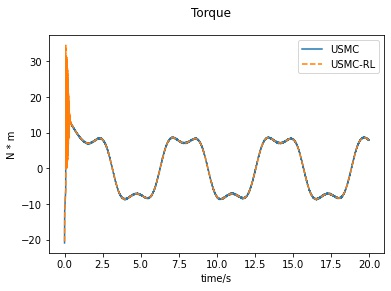

In [45]:
plt.suptitle('Torque')
plt.plot(time_list, torque_l2, label="USMC")
plt.plot(time_list, torque_l, label="USMC-RL", linestyle='dashed')
plt.xlabel('time/s')
plt.ylabel('N * m')
plt.legend()

In [46]:
# sum of output torque
np.sum(abs(np.array(torque_l2))), np.sum(abs(np.array(torque_l)))

(27640.892283840752, 27649.96022437699)

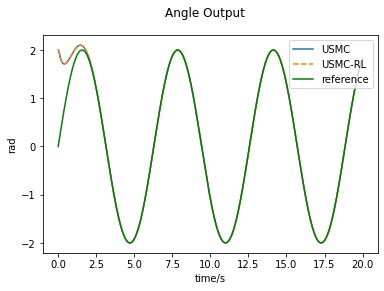

In [47]:
plt.suptitle('Angle Output')
plt.plot(time_list, th_list2, label="USMC")
plt.plot(time_list, th_list, label="USMC-RL", linestyle='dashed')
plt.plot(time_list, th_r, 'g', label="reference")
plt.xlabel('time/s')
plt.ylabel('rad')
plt.legend()

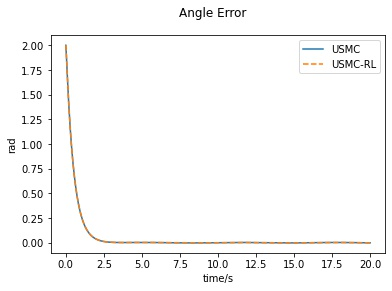

In [48]:
plt.suptitle('Angle Error')
plt.plot(time_list, np.array(th_list2) - np.array(th_r), label="USMC")
plt.plot(time_list, np.array(th_list) - np.array(th_r), label="USMC-RL", linestyle='dashed')
plt.xlabel('time/s')
plt.ylabel('rad')
plt.legend()

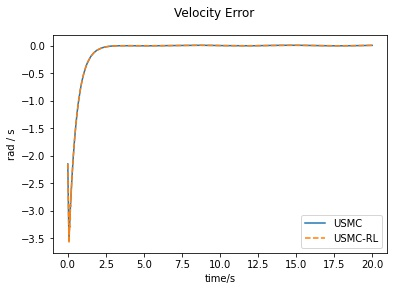

In [49]:
plt.suptitle('Velocity Error')
plt.plot(time_list, np.array(thdot_list2) - np.array(thdot_r), label="USMC")
plt.plot(time_list, np.array(thdot_list) - np.array(thdot_r), label="USMC-RL", linestyle='dashed')
plt.xlabel('time/s')
plt.ylabel('rad / s')
plt.legend()

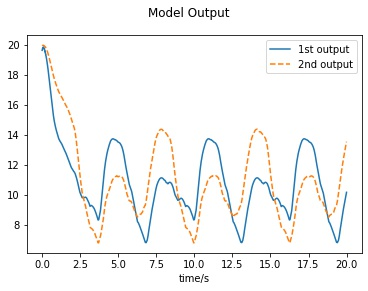

In [50]:
action_l1 = []
action_l2 = []
for i in range(len(action_l)):
    action_l1.append(action_l[i][0].numpy())
    action_l2.append(action_l[i][1].numpy())

plt.suptitle('Model Output')
plt.plot(time_list, action_l1, label="1st output")
plt.plot(time_list, action_l2, label="2nd output", linestyle='dashed')
plt.xlabel('time/s')
plt.legend()

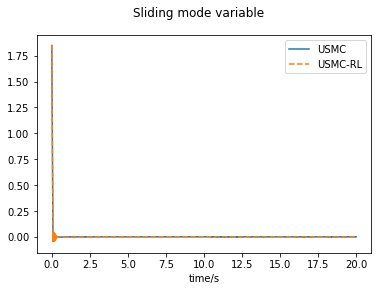

In [53]:
plt.suptitle('Sliding mode variable')
plt.plot(time_list[:], s_l2[:], label="USMC")
plt.plot(time_list[:], s_l[:], label="USMC-RL", linestyle='dashed')
plt.xlabel('time/s')
plt.legend()

In [52]:
np.sum(abs(np.array(s_l[:4000]))), np.sum(abs(np.array(s_l2[:4000])))

(16.791383361258926, 16.40283125865358)

# save model

In [35]:
# agent.actor.save('2022-02-02-1-Noise-Sine-SMC-actor.hdf5')
# agent.actor_target.save('2022-02-02-1-Noise-Sine-SMC-actor_target.hdf5')
# agent.critic.save('2022-02-02-1-Noise-Sine-SMC-critic.hdf5')
# agent.critic_target.save('2022-02-02-1-Noise-Sine-SMC-critic_target.hdf5')

# Visualization

In [45]:
value0 = np.zeros((200, 200))
value1 = np.zeros((200, 200))
for i in range(0, 200):
    for j in range(0, 200):
        value = agent.get_action(np.array([0, 0, float((i-100)/50), float((j-100)/50)]), greedy=True).numpy()
        #print(i, j)
        value0[i][j] = value[0]
        value1[i][j] = value[0]
        # ax.scatter3D(i, j, value[i][j], c=value[i][j], cmap='Greens');

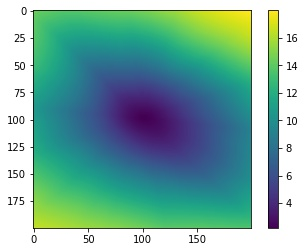

In [46]:
plt.imshow(value0)
plt.colorbar()

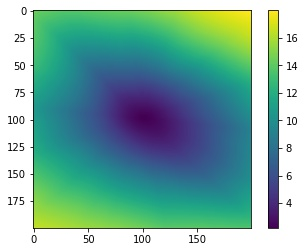

In [47]:
plt.imshow(value1)
plt.colorbar()

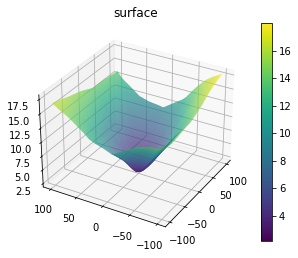

In [48]:
x = np.linspace(-100, 100, 200)
y = np.linspace(-100, 100, 200)
X, Y = np.meshgrid(x, y)
Z = value0
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');
ax.view_init(30, 210)

C = np.linspace(np.min(value0), np.max(value0), 40000).reshape(value1.shape)
scamap = plt.cm.ScalarMappable(cmap='viridis')
fcolors = scamap.to_rgba(C)


#scamap = plt.cm.ScalarMappable(cmap='viridis')

# fcolors = scamap.to_rgba(C)
# ax.plot_surface(X, Y, Z, facecolors=fcolors, cmap='viridis')
fig.colorbar(scamap)

plt.show()

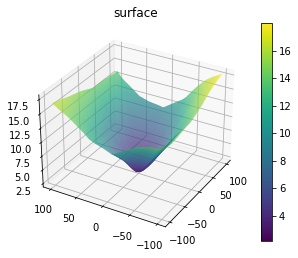

In [49]:
x = np.linspace(-100, 100, 200)
y = np.linspace(-100, 100, 200)
X, Y = np.meshgrid(x, y)
Z = value1
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');
ax.view_init(30, 210)

C = np.linspace(np.min(value1), np.max(value1), 40000).reshape(value1.shape)
scamap = plt.cm.ScalarMappable(cmap='viridis')
fcolors = scamap.to_rgba(C)


#scamap = plt.cm.ScalarMappable(cmap='viridis')

# fcolors = scamap.to_rgba(C)
# ax.plot_surface(X, Y, Z, facecolors=fcolors, cmap='viridis')
fig.colorbar(scamap)

plt.show()

# combining U-model

In [7]:
import sympy
import copy
t3, s3 = sympy.symbols('t, s')

env = PendulumSMCEnv()
env.dt=0.005

th_r = []
thdot_r = []

# test
# agent.load()
th_list = []
thdot_list = []
action_l = []
torque_l = []
s_l = []
eth_list =[]
ethdot_list=[]

for episode in range(1):
    # state initialisation
    state = env.reset()
    env.state = np.array([2, 1, 2, 0], dtype=np.float32)
    
    episode_reward = 0
    
    '''
        
    ############# Constant target angle
    target = np.array([1, 0])
    target0 = target[0]
    target1 = target[1]

    target0 = target0 / s3
    target1 = target1 / s3

    transfer = 25 / (s3**2 + 10 * s3 +25)
    target0 = sympy.Mul(target0, transfer)
    target1 = sympy.Mul(target1, transfer)
    itransfer0 = sympy.inverse_laplace_transform(target0, s3, t3)
    itransfer1 = sympy.inverse_laplace_transform(target1, s3, t3)
    #############################
    '''
    
    # Target specification
        
    ############# sine target angle
    target = np.array([2 * np.sin(0.5*step*env.dt), 1 * np.cos(0.5*step*env.dt)])
    target0 = 2 * 0.5 / (s3**2 + 0.25)
    target1 = s3 / (s3**2 + 0.25)
    itransfer0 = sympy.inverse_laplace_transform(2500/(100*s3**4+1000*s3**3+2525*s3**2+250*s3+625), s3, t3).evalf().simplify()
    itransfer1 = sympy.inverse_laplace_transform(2500*s3/(100*s3**4+1000*s3**3+2525*s3**2+250*s3+625), s3, t3).evalf().simplify()
        
        
    for step in range(10000):
        
        if step%100 == 0:
            print(step)
            
        noise = (np.random.random()-0.5) * 2 * 0.01

        
        
        #################################
        
        
        # get timie-domain value
        value0 = itransfer0.evalf(subs ={'t':env.dt*(step+1)})
        value1 = itransfer1.evalf(subs ={'t':env.dt*(step+1)})
        target = np.array([value0, value1])
    
    
    
        #target = np.array([0, 0])
        th_r.append(2 * np.sin(0.5*step*env.dt))
        thdot_r.append(1 * np.cos(0.5*step*env.dt))
        
        state, reward, done, info, torque, s = env.step(agent.get_action(state, greedy=True), target, 0)
        
        th_list.append(state[0])
        thdot_list.append(state[1])
        eth_list.append(state[2])
        ethdot_list.append(state[3])
        action_l.append(agent.get_action(state, greedy=True))
        torque_l.append(float(torque))
        s_l.append(float(s))
        
        episode_reward += reward
        if done:
            break
    print(
        'Testing  | Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
            episode + 1, TEST_EPISODES, episode_reward,
            time.time() - t0
        )
    )

D:\Anaconda3\envs\tf-cpu\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
Testing  | Episode: 1/10  | Episode Reward: -17040.1960  | Running Time: 246.9011
